In [6]:
# external libraries
!python -m pip install -U plotly
!python -m pip install -U gensim
!python -m pip install -U kneed
!python -m pip install -U scikit-learn
!python -m pip install -U pyLDAvis
!python -m pip install -U torchvision 
!python -m pip install -U spacy 

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1]:
# libraries used
import pandas as pd
import numpy as np 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt 
import seaborn as sns

#!pip install kneed
from kneed import KneeLocator

from sklearn.cluster import KMeans 
from scipy.cluster import hierarchy 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.mixture import GaussianMixture

from gensim.models.doc2vec import Doc2Vec

from gensim.models.coherencemodel import CoherenceModel
from scipy.cluster.hierarchy import linkage as lkg

from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis

import pyLDAvis.gensim_models as gensimvis
%matplotlib inline
from sklearn.cluster import KMeans
from gensim.matutils import corpus2csc
import torch
import torchvision

# customized helper functions
import measures

D:\anaconda\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# render setting for vscode
import plotly.io as pio
pio.renderers.default = "notebook"

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Helper functions

In [3]:
def make_SVDtsne_2d(data, label=None, books=('a','b','c','d','e')):
  reduced = TruncatedSVD(n_components=5, random_state=0).fit_transform(data)

  tsne_results = TSNE(n_components=2, 
                      perplexity=40, 
                      init='pca', # globally more stable to initialization
                      learning_rate = 'auto',
                      n_iter=1000, 
                      random_state=0).fit_transform(reduced)

  df_out = pd.DataFrame()
  df_out['tsne-2d-one'] = tsne_results[:,0]
  df_out['tsne-2d-two'] = tsne_results[:,1]
  df_out['label_True'] = df['label'].loc[df['label'].isin(books)].reset_index(drop=True)
  print(df_out)
  if label is not None:
    dic = dict(enumerate(df['label'].loc[df['label'].isin(books)].unique()))
    lbl = list(label)
    for i, l in zip(range(0,len(lbl)), lbl):
      try:
        lbl[i] = dic[l].upper()
      except:
        lbl[i] = 'Outlier'
    df_out['label_Pred'] = lbl
  
  print(df_out)
  if label is None: fig = px.scatter(df_out, x='tsne-2d-one', y='tsne-2d-two', color="label_True", symbol="label_True", width=1200, height=900)
  if label is not None: fig = px.scatter(df_out, x='tsne-2d-one', y='tsne-2d-two', color="label_Pred", symbol="label_True", width=1200, height=900)

  fig.show()

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [4]:
def make_tsne_2d(data, label=None, books=('a','b','c','d','e')):
    # need to read raw our.csv first
    # df must be vectorized DataFrame
    
    tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, random_state=0)
    tsne_results = tsne.fit_transform(data)
    
    df_out = pd.DataFrame()
    df_out['tsne-2d-one'] = tsne_results[:,0]
    df_out['tsne-2d-two'] = tsne_results[:,1]
    df_out['label_True'] = df['label'].loc[df['label'].isin(books)].reset_index(drop=True)
    if label is not None:
      dic = dict(enumerate(df['label'].unique()))
      lbl = list(label)
      for i, l in zip(range(0,len(lbl)), lbl):
        try:
          lbl[i] = dic[l].upper()
        except:
          lbl[i] = 'Outlier'
      df_out['label_Pred'] = lbl
    
    if label is None: fig = px.scatter(df_out, x='tsne-2d-one', y='tsne-2d-two', color="label_True", symbol="label_True", width=1200, height=900)
    if label is not None: fig = px.scatter(df_out, x='tsne-2d-one', y='tsne-2d-two', color="label_Pred", symbol="label_True", width=1200, height=900)
    fig.show()

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [69]:
def elbow_method(data, number):
    wcss = []
    for i in range(1, number+1):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    kn = KneeLocator(range(1, 10+1), wcss, curve='convex', direction='decreasing')

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(1, number+1)),
                            y=wcss))
    fig.add_vline(x=kn.knee, line_width=3, line_dash="dash", line_color="green")

    fig.update_layout(title='Elbow Method',
                      xaxis_title='Number of clusters',
                      yaxis_title='WCSS',
                      title_x=0.5,
                      height=500, 
                      width=800)
    fig.show()

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [6]:
def compare_predict(trans_data, data, modl, vidl = None,
  n_clusters=5,
  linkage='ward',
  n_components = 2,
  covariance_type = 'diag',
  random_state = 0,
  books=('a','b','c','d','e')):

  X = trans_data[data['label'].isin(books)]

  # clustering parameters
  if 'n_clusters' in modl.get_params():
    modl.set_params(n_clusters = n_clusters)
  if 'linkage' in modl.get_params():
    modl.set_params(linkage = linkage)
  # em parameters
  if 'n_components' in modl.get_params():
    modl.set_params(n_components = n_components)
  if 'covariance_type' in modl.get_params():
    modl.set_params(covariance_type = covariance_type)
  if 'random_state' in modl.get_params():
    modl.set_params(random_state = random_state)

  pred = modl.fit_predict(X)

  pred_map = measures.label_to_cluster_num(pred=pred, k=len(books), books= books)
  label_data_in_books = data[data['label'].isin(books)]['label'] # retrieve label rows that belongs to any of the books
  mapped_label = [pred_map[label] for label in label_data_in_books]

  if vidl is not None:
    if vidl == 'tsne':
      make_tsne_2d(X, pred, books)
    if vidl == 'SVDtsne':
      make_SVDtsne_2d(X, pred, books)
    if vidl == 'agglom':
      fig = ff.create_dendrogram(X, orientation='left', labels=pred, linkagefun=lambda x: lkg(X, linkage, metric='euclidean'))
      fig.update_layout(height=2000, width=1200)
      fig.show()

  return modl, pred, np.array(mapped_label)

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [7]:
# Fetch data from google drive. equivalent to out.csv
df = pd.read_csv("./books_data.csv")
df

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,partition,label
0,"['project', 'gutenberg', 'ebook', 'peter', 'pa...",a
1,"['project', 'gutenberg', 'ebook', 'peter', 'pa...",a
2,"['stori', 'chapter', 'xii', 'child', 'carri', ...",a
3,"['subject', 'henceforth', 'wendi', 'knew', 'mu...",a
4,"['love', 'ran', 'hous', 'propos', 'except', 'M...",a
...,...,...
995,"['face', 'may', 'may', 'Mr', 'holm', 'said', '...",e
996,"['sight', 'bitter', 'sneer', 'upon', 'man', 'f...",e
997,"['entir', 'devoid', 'interest', 'entir', 'see'...",e
998,"['handwrit', 'familiar', 'would', 'recognis', ...",e


### BOW

In [8]:
# Create CountVectorizer object
bow_vec = CountVectorizer()
# Generate matrix of word vectors
bow_matrix = bow_vec.fit_transform(df['partition'])
# print(bow_matrix.toarray())
df_bow = pd.DataFrame(bow_matrix.toarray())
df_bow.columns = bow_vec.get_feature_names_out()
df_bow


D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,07,10,108,10annett,11,112,113,118,12,1228,...,youngster,your_,yousit,youth,zealand,zigzag,zoologist,çela,émigré,œuvr
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
elbow_method(df_bow, 10)

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks

##### K Means

In [73]:
bow_kmeans5, bow_kmeans5_pred, bow_kmeans5_cluster_num = compare_predict(df_bow, df, KMeans(), 'SVDtsne', n_clusters= 5)

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



a:[  0   0 172  28   0]	a mapped to 2
b:[131   0   7   1  61]	b mapped to 0
c:[  0   6 194   0   0]	c mapped to 2
d:[  1   0  75 124   0]	d mapped to 3
e:[  0   0 173  27   0]	e mapped to 2
     tsne-2d-one  tsne-2d-two label_True
0      10.106979   -18.976862          a
1      16.658756    17.278454          a
2      16.962790    16.803854          a
3      15.724574   -18.503958          a
4      15.815999   -17.550358          a
..           ...          ...        ...
995    12.582503    -4.734419          e
996     8.869046    -0.092569          e
997     7.469799     4.586647          e
998    -0.550355     4.350588          e
999     4.664956     5.487884          e

[1000 rows x 3 columns]
     tsne-2d-one  tsne-2d-two label_True label_Pred
0      10.106979   -18.976862          a          C
1      16.658756    17.278454          a          C
2      16.962790    16.803854          a          C
3      15.724574   -18.503958          a          C
4      15.815999   -17.550358    

##### EM

In [74]:
bow_gmm5, bow_gmm5_pred, bow_gmm5_cluster_num = compare_predict(df_bow, df, GaussianMixture(), 'SVDtsne', n_clusters=5)

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



a:[ 24 158   0   0  18]	a mapped to 1
b:[  1  62   0 136   1]	b mapped to 3
c:[  0  40   6   0 154]	c mapped to 4
d:[119  81   0   0   0]	d mapped to 0
e:[ 23 176   0   0   1]	e mapped to 1
     tsne-2d-one  tsne-2d-two label_True
0      10.106979   -18.976862          a
1      16.658756    17.278454          a
2      16.962790    16.803854          a
3      15.724574   -18.503958          a
4      15.815999   -17.550358          a
..           ...          ...        ...
995    12.582503    -4.734419          e
996     8.869046    -0.092569          e
997     7.469799     4.586647          e
998    -0.550355     4.350588          e
999     4.664956     5.487884          e

[1000 rows x 3 columns]
     tsne-2d-one  tsne-2d-two label_True label_Pred
0      10.106979   -18.976862          a          B
1      16.658756    17.278454          a          B
2      16.962790    16.803854          a          B
3      15.724574   -18.503958          a          B
4      15.815999   -17.550358    

##### Hierarchical 

In [75]:
bow_agglom5, bow_agglom5_pred, bow_agglom5_cluster_num = compare_predict(df_bow, df, AgglomerativeClustering(), 'SVDtsne', n_clusters=5, linkage='ward')

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



a:[  1   3 196   0   0]	a mapped to 2
b:[198   0   2   0   0]	b mapped to 0
c:[  1 167  26   1   5]	c mapped to 1
d:[  5   0 195   0   0]	d mapped to 2
e:[  1   0 199   0   0]	e mapped to 2
     tsne-2d-one  tsne-2d-two label_True
0      10.106979   -18.976862          a
1      16.658756    17.278454          a
2      16.962790    16.803854          a
3      15.724574   -18.503958          a
4      15.815999   -17.550358          a
..           ...          ...        ...
995    12.582503    -4.734419          e
996     8.869046    -0.092569          e
997     7.469799     4.586647          e
998    -0.550355     4.350588          e
999     4.664956     5.487884          e

[1000 rows x 3 columns]
     tsne-2d-one  tsne-2d-two label_True label_Pred
0      10.106979   -18.976862          a          A
1      16.658756    17.278454          a          C
2      16.962790    16.803854          a          C
3      15.724574   -18.503958          a          C
4      15.815999   -17.550358    

### TF-IDF

In [13]:
tfidf_vec = TfidfVectorizer()
tfidf_matrix = tfidf_vec.fit_transform(df['partition'])
df_tfidf = pd.DataFrame(tfidf_matrix.toarray())
df_tfidf.columns = tfidf_vec.get_feature_names_out()

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



##### K Means

In [76]:
tfidf_kmeans5, tfidf_kmeans5_pred, tfidf_kmeans5_cluster_num = compare_predict(df_tfidf, df, KMeans(), 'SVDtsne', n_clusters= 5)

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



a:[ 16 183   1   0   0]	a mapped to 1
b:[ 12   0   1   0 187]	b mapped to 4
c:[  6   0   6 188   0]	c mapped to 3
d:[ 62   0 137   0   1]	d mapped to 2
e:[200   0   0   0   0]	e mapped to 0
     tsne-2d-one  tsne-2d-two label_True
0       0.882292   -11.440311          a
1      15.877926    20.745714          a
2      15.856339    20.740122          a
3       2.859772   -24.406652          a
4       2.882373   -24.701563          a
..           ...          ...        ...
995    -6.087939     6.837444          e
996    -5.237791     3.227826          e
997     1.291551     5.203737          e
998     2.955148     0.402749          e
999    -0.107048     3.285957          e

[1000 rows x 3 columns]
     tsne-2d-one  tsne-2d-two label_True label_Pred
0       0.882292   -11.440311          a          A
1      15.877926    20.745714          a          C
2      15.856339    20.740122          a          B
3       2.859772   -24.406652          a          B
4       2.882373   -24.701563    

##### EM

In [77]:
tfidf_gmm5, tfidf_gmm5_pred, tfidf_gmm5_cluster_num = compare_predict(df_tfidf, df, GaussianMixture(), 'SVDtsne', n_components=5)

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



a:[  0   0   0 180  20]	a mapped to 3
b:[  0   0 197   0   3]	b mapped to 2
c:[  6 168   0   0  26]	c mapped to 1
d:[185   0   1   0  14]	d mapped to 0
e:[  0   0   0   0 200]	e mapped to 4
     tsne-2d-one  tsne-2d-two label_True
0       0.882292   -11.440311          a
1      15.877926    20.745714          a
2      15.856339    20.740122          a
3       2.859772   -24.406652          a
4       2.882373   -24.701563          a
..           ...          ...        ...
995    -6.087939     6.837444          e
996    -5.237791     3.227826          e
997     1.291551     5.203737          e
998     2.955148     0.402749          e
999    -0.107048     3.285957          e

[1000 rows x 3 columns]
     tsne-2d-one  tsne-2d-two label_True label_Pred
0       0.882292   -11.440311          a          D
1      15.877926    20.745714          a          D
2      15.856339    20.740122          a          D
3       2.859772   -24.406652          a          D
4       2.882373   -24.701563    

##### Hierarchical

In [78]:
tfidf_agglom5, tfidf_agglom5_pred, tfidf_agglom5_cluster_num = compare_predict(df_tfidf, df, AgglomerativeClustering(), 'SVDtsne', n_clusters=5, linkage='ward')

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



a:[  8   0 190   0   2]	a mapped to 2
b:[  6 193   1   0   0]	b mapped to 1
c:[ 10   0   1 183   6]	c mapped to 3
d:[192   0   1   2   5]	d mapped to 0
e:[200   0   0   0   0]	e mapped to 0
     tsne-2d-one  tsne-2d-two label_True
0       0.882292   -11.440311          a
1      15.877926    20.745714          a
2      15.856339    20.740122          a
3       2.859772   -24.406652          a
4       2.882373   -24.701563          a
..           ...          ...        ...
995    -6.087939     6.837444          e
996    -5.237791     3.227826          e
997     1.291551     5.203737          e
998     2.955148     0.402749          e
999    -0.107048     3.285957          e

[1000 rows x 3 columns]
     tsne-2d-one  tsne-2d-two label_True label_Pred
0       0.882292   -11.440311          a          A
1      15.877926    20.745714          a          E
2      15.856339    20.740122          a          E
3       2.859772   -24.406652          a          C
4       2.882373   -24.701563    

### LDA

### Doc2Vec

#### Doc2Vec is a very popular transformer, which is developed based on Word2Vec and can describe the information of paragraphs very well. However, it’s a very complicated model which relies on the computing resource deeply. Also, the choices of training sample and hyper parameters would directly affect the performance of the model. Particularly, the value of vector size, window, and minimum count, would be some of the most important hyper parameters.

#### So, in our case, for the reason of the limitation of our data set and computer performance, we use 5 books to train the model with the hyper parameters of vector size = 2000, window = 10, minimum count = 10, and use it as the pretrained transformer for the next step.


In [148]:
# Load the pretrained Doc2Vec transformer
d2v_model = Doc2Vec.load('./doc2vec.model')
d2v_model_high = Doc2Vec.load('./doc2vec_high.model')
d2v_model_low = Doc2Vec.load('./doc2vec_low.model')

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [149]:
#generate the list of tokenized words
text_list = df['partition'].values.tolist()

tokenized_list = []
for segment in text_list:
    tokenized_segment = segment.split()
    tokenized_list.append(tokenized_segment)

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [150]:
#generate the list of word vectors
x_d2v = [d2v_model.infer_vector(d) for d in tokenized_list]
df_d2v = pd.DataFrame(x_d2v)
# df_d2v

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



##### K Means

In [151]:
d2v_kmeans5, d2v_kmeans5_pred, d2v_kmeans5_cluster_num = compare_predict(df_d2v, df, KMeans(), 'SVDtsne', n_clusters= 5)

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



a:[145   0  51   1   3]	a mapped to 0
b:[  0 125   2  73   0]	b mapped to 1
c:[131   0  52   1  16]	c mapped to 0
d:[ 57   0 125   4  14]	d mapped to 2
e:[ 31   0 165   3   1]	e mapped to 2
     tsne-2d-one  tsne-2d-two label_True
0      34.465122     5.724604          a
1     -12.120211    22.839550          a
2     -13.304577    22.774027          a
3     -26.404158   -10.624104          a
4     -33.931431    -5.960694          a
..           ...          ...        ...
995     3.427017    -8.445251          e
996     6.637572    -1.563444          e
997    17.039309    -1.234644          e
998    13.882740    -5.491142          e
999    -0.691114    -5.876740          e

[1000 rows x 3 columns]
     tsne-2d-one  tsne-2d-two label_True label_Pred
0      34.465122     5.724604          a          D
1     -12.120211    22.839550          a          E
2     -13.304577    22.774027          a          E
3     -26.404158   -10.624104          a          A
4     -33.931431    -5.960694    

##### Hierarchical

In [152]:
d2v_agglom5, d2v_agglom5_pred, d2v_agglom5_cluster_num = compare_predict(df_d2v, df, AgglomerativeClustering(), 'SVDtsne', n_clusters=5, linkage='ward')

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



a:[  1   2  46 135  16]	a mapped to 3
b:[196   0   4   0   0]	b mapped to 0
c:[  1   4  63  24 108]	c mapped to 4
d:[  3   4 120  23  50]	d mapped to 2
e:[  1   1 158  27  13]	e mapped to 2
     tsne-2d-one  tsne-2d-two label_True
0      34.465122     5.724604          a
1     -12.120211    22.839550          a
2     -13.304577    22.774027          a
3     -26.404158   -10.624104          a
4     -33.931431    -5.960694          a
..           ...          ...        ...
995     3.427017    -8.445251          e
996     6.637572    -1.563444          e
997    17.039309    -1.234644          e
998    13.882740    -5.491142          e
999    -0.691114    -5.876740          e

[1000 rows x 3 columns]
     tsne-2d-one  tsne-2d-two label_True label_Pred
0      34.465122     5.724604          a          A
1     -12.120211    22.839550          a          B
2     -13.304577    22.774027          a          B
3     -26.404158   -10.624104          a          D
4     -33.931431    -5.960694    

##### EM

In [153]:
d2v_gmm5, d2v_gmm5_pred, d2v_gmm5_cluster_num = compare_predict(df_d2v, df, GaussianMixture(), 'SVDtsne', n_components=5)

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



a:[ 24   0 130  45   1]	a mapped to 2
b:[  0  66   0   2 132]	b mapped to 4
c:[ 53   0 111  35   1]	c mapped to 2
d:[ 32   0  55 111   2]	d mapped to 3
e:[  5   0  39 154   2]	e mapped to 3
     tsne-2d-one  tsne-2d-two label_True
0      34.465122     5.724604          a
1     -12.120211    22.839550          a
2     -13.304577    22.774027          a
3     -26.404158   -10.624104          a
4     -33.931431    -5.960694          a
..           ...          ...        ...
995     3.427017    -8.445251          e
996     6.637572    -1.563444          e
997    17.039309    -1.234644          e
998    13.882740    -5.491142          e
999    -0.691114    -5.876740          e

[1000 rows x 3 columns]
     tsne-2d-one  tsne-2d-two label_True label_Pred
0      34.465122     5.724604          a          E
1     -12.120211    22.839550          a          A
2     -13.304577    22.774027          a          A
3     -26.404158   -10.624104          a          C
4     -33.931431    -5.960694    

### Evaluation

##### Kappa Score

In [154]:
print("Kappa score for BOW----------------------------------")
bow_kmeans5.kappa = measures.get_kappa(bow_kmeans5_pred, bow_kmeans5_cluster_num)
bow_agglom5.kappa = measures.get_kappa(bow_agglom5_pred, bow_agglom5_cluster_num)
bow_gmm5.kappa = measures.get_kappa(bow_gmm5_pred, bow_gmm5_cluster_num)
print("Kappa score for TFIDF--------------------------------")
tfidf_kmeans5.kappa = measures.get_kappa(tfidf_kmeans5_pred, tfidf_kmeans5_cluster_num)
tfidf_agglom5.kappa = measures.get_kappa(tfidf_agglom5_pred, tfidf_agglom5_cluster_num)
tfidf_gmm5.kappa = measures.get_kappa(tfidf_gmm5_pred, tfidf_gmm5_cluster_num)
print("Kappa score for LDA----------------------------------")

print("Kappa score for Doc2Vec------------------------------")
d2v_kmeans5.kappa = measures.get_kappa(d2v_kmeans5_pred, d2v_kmeans5_cluster_num)
d2v_agglom5.kappa = measures.get_kappa(d2v_agglom5_pred, d2v_agglom5_cluster_num)
d2v_gmm5.kappa = measures.get_kappa(d2v_gmm5_pred, d2v_gmm5_cluster_num)

Kappa score for BOW----------------------------------
kappa: 0.6353982300884955
kappa: 0.9187725631768953
kappa: 0.6316996274004012
Kappa score for TFIDF--------------------------------
kappa: 0.86875
kappa: 0.9416180150125104
kappa: 0.9125
Kappa score for LDA----------------------------------
Kappa score for Doc2Vec------------------------------
kappa: 0.5397676496872208
kappa: 0.6091160220994476
kappa: 0.48256146369353914


D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [155]:
model_name = [['bow kmean5', 'bow agglom5', 'bow em5'],
                ['tfidf kmean5', 'tfidf agglom5', 'tfidf em5'],
        ['d2v kmean5', 'd2v agglom5', 'd2v em5']]

scores_kappa = [[bow_kmeans5.kappa, bow_agglom5.kappa, bow_gmm5.kappa,],
        [tfidf_kmeans5.kappa, tfidf_agglom5.kappa, tfidf_gmm5.kappa],
        [d2v_kmeans5.kappa, d2v_agglom5.kappa, d2v_gmm5.kappa]
        ]

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [156]:
np.arange(40, 160,40)

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



array([ 40,  80, 120])

In [157]:
import plotly.graph_objects as go
fig = go.Figure()
COLOR_FEATURE = np.arange(100, 250, 50)
COLOR_MODEL = np.arange(40,160,40)

for i, color_feature in enumerate(COLOR_FEATURE):
    for j, color_model in enumerate(COLOR_MODEL):
        fig.add_trace(go.Bar(x = [model_name[i][j]],
                            y = [scores_kappa[i][j]],
                            name = model_name[i][j],
                            marker_color= 'rgb('+str(color_feature)+', 120,'+str(color_model)+')',
                            text= [scores_kappa[i][j]]
                            ))

fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.update_layout(
    title_text='Kappa Scores for Different Models'
)
fig.show()

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



##### Silhouette Score

In [158]:
print("silhouette score for BOW----------------------------------")
bow_kmeans5.silhouette = measures.get_silhouette_score(df_bow, bow_kmeans5_cluster_num)
bow_agglom5.silhouette = measures.get_silhouette_score(df_bow, bow_agglom5_cluster_num)
bow_gmm5.silhouette = measures.get_silhouette_score(df_bow, bow_gmm5_cluster_num)
print("silhouette score for TFIDF--------------------------------")
tfidf_kmeans5.silhouette = measures.get_silhouette_score(df_tfidf, tfidf_kmeans5_cluster_num)
tfidf_agglom5.silhouette = measures.get_silhouette_score(df_tfidf, tfidf_agglom5_cluster_num)
tfidf_gmm5.silhouette = measures.get_silhouette_score(df_tfidf, tfidf_gmm5_cluster_num)
print("silhouette score for LDA----------------------------------")

print("silhouette score for Doc2Vec------------------------------")
d2v_kmeans5.silhouette = measures.get_silhouette_score(df_d2v, d2v_kmeans5_cluster_num)
d2v_agglom5.silhouette = measures.get_silhouette_score(df_d2v, d2v_agglom5_cluster_num)
d2v_gmm5.silhouette = measures.get_silhouette_score(df_d2v, d2v_gmm5_cluster_num)

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



silhouette score for BOW----------------------------------
silhouette score: -0.010746005881800925
silhouette score: 0.030766885106553787
silhouette score: -0.015654155583308342
silhouette score for TFIDF--------------------------------
silhouette score: 0.015938982014651895
silhouette score: 0.014480528063594794
silhouette score: 0.015938982014651895
silhouette score for LDA----------------------------------
silhouette score for Doc2Vec------------------------------
silhouette score: 0.21666964888572693
silhouette score: 0.19424593448638916
silhouette score: 0.21666964888572693


In [159]:
scores_silhouette = [[bow_kmeans5.silhouette, bow_agglom5.silhouette, bow_gmm5.silhouette],
        [tfidf_kmeans5.silhouette, tfidf_agglom5.silhouette, tfidf_gmm5.silhouette],
        
        [d2v_kmeans5.silhouette, d2v_agglom5.silhouette, d2v_gmm5.silhouette]
        ]

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [160]:
fig = go.Figure()

for i, color_feature in enumerate(COLOR_FEATURE):
    for j, color_model in enumerate(COLOR_MODEL):
        fig.add_trace(go.Bar(x = [model_name[i][j]],
                            y = [scores_silhouette[i][j]],
                            name = model_name[i][j],
                            marker_color= 'rgb('+str(color_feature)+', 120,'+str(color_model)+')',
                            text= [scores_silhouette[i][j]]
                            ))

fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.update_layout(
    title_text='Silhouette Scores for Different Models'
)
fig.show()

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



##### Coherence

##### Rand Index

In [161]:
print("Rand score for BOW----------------------------------")
bow_kmeans5.rand = measures.get_rand_score(bow_kmeans5_pred, bow_kmeans5_cluster_num)
bow_agglom5.rand = measures.get_rand_score(bow_agglom5_pred, bow_agglom5_cluster_num)
bow_gmm5.rand = measures.get_rand_score(bow_gmm5_pred, bow_gmm5_cluster_num)
print("Rand score for TFIDF--------------------------------")
tfidf_kmeans5.rand = measures.get_rand_score(tfidf_kmeans5_pred, tfidf_kmeans5_cluster_num)
tfidf_agglom5.rand = measures.get_rand_score(tfidf_agglom5_pred, tfidf_agglom5_cluster_num)
tfidf_gmm5.rand = measures.get_rand_score(tfidf_gmm5_pred, tfidf_gmm5_cluster_num)
print("Rand score for LDA----------------------------------")

print("Rand score for Doc2Vec------------------------------")
d2v_kmeans5.rand = measures.get_rand_score(d2v_kmeans5_pred, d2v_kmeans5_cluster_num)
d2v_agglom5.rand = measures.get_rand_score(d2v_agglom5_pred, d2v_agglom5_cluster_num)
d2v_gmm5.rand = measures.get_rand_score(d2v_gmm5_pred, d2v_gmm5_cluster_num)

Rand score for BOW----------------------------------
rand score: 0.5769166160437706
rand score: 0.8757142298847865
rand score: 0.3984734040680507
Rand score for TFIDF--------------------------------
rand score: 0.7578715548013332
rand score: 0.8997573557544473
rand score: 0.827566659837573
Rand score for LDA----------------------------------
Rand score for Doc2Vec------------------------------
rand score: 0.39175220131832955
rand score: 0.4124141434274827
rand score: 0.3468063030975181


D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [162]:
scores_rand = [[bow_kmeans5.rand, bow_agglom5.rand, bow_gmm5.rand],
        [tfidf_kmeans5.rand, tfidf_agglom5.rand, tfidf_gmm5.rand],
        
        [d2v_kmeans5.rand, d2v_agglom5.rand, d2v_gmm5.rand]
        ]

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [163]:
fig = go.Figure()

for i, color_feature in enumerate(COLOR_FEATURE):
    for j, color_model in enumerate(COLOR_MODEL):
        fig.add_trace(go.Bar(x = [model_name[i][j]],
                            y = [scores_rand[i][j]],
                            name = model_name[i][j],
                            marker_color= 'rgb('+str(color_feature)+', 120,'+str(color_model)+')',
                            text= [scores_rand[i][j]]
                            ))

fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.update_layout(
    title_text='Rand Index for Different Models'
)
fig.show()

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Error Analysis doc2vec kmeans(n_cluster = 5)

In [164]:
d2v_kmeans5, d2v_kmeans5_pred, d2v_kmeans5_cluster_num = compare_predict(df_d2v, df, KMeans(), n_clusters=5)

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



a:[145   0  51   1   3]	a mapped to 0
b:[  0 125   2  73   0]	b mapped to 1
c:[131   0  52   1  16]	c mapped to 0
d:[ 57   0 125   4  14]	d mapped to 2
e:[ 31   0 165   3   1]	e mapped to 2


In [171]:
topn95 = 10 # topn for similarity above .95
test_cluster = 2
while d2v_model.wv.most_similar(positive=d2v_kmeans5.cluster_centers_[test_cluster], topn=topn95)[-1][1] > 0.99:
    topn95 = topn95 + 5

print(topn95)
    
most_similar_words_5 = d2v_model.wv.most_similar(positive=d2v_kmeans5.cluster_centers_[test_cluster], topn=topn95)
list_most_similar_words_5 = [word[0] for word in most_similar_words_5]

a_dict = dict()
for k in range(0,5):
    for i, segment in enumerate(tokenized_list[k*200:k*200+200]):
        for word in segment:
            if word in list_most_similar_words_5:
                if k not in a_dict:
                    a_dict[k] = dict()
                if word not in a_dict[k]:
                    a_dict[k][word] = 1
                else:
                    a_dict[k][word] = a_dict[k][word] + 1
for k in range(0, 5):
    total_count = sum(a_dict[k].values())
    print("[{}to{}]len set: {} -------- len list: {}".
    format(k*200, k*200+200, len(a_dict[k]), total_count))

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



380
[0to200]len set: 311 -------- len list: 2050
[200to400]len set: 124 -------- len list: 331
[400to600]len set: 326 -------- len list: 2526
[600to800]len set: 276 -------- len list: 2028
[800to1000]len set: 304 -------- len list: 2097


In [172]:
COLOR_LABEL = np.arange(50, 300, 50)
list_unique_similar_word = dict()
list_unique_similar_word_freq = dict()
for i in range(0, 5):
    list_unique_similar_word[i] = list()
    list_unique_similar_word_freq[i] = list()
    for word in a_dict[i]:
        list_unique_similar_word[i].append(word)
        list_unique_similar_word_freq[i].append(a_dict[i][word])


D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [173]:
fig = go.Figure()
for i, color_label in enumerate(COLOR_LABEL):
    fig.add_trace(go.Bar(x = list_unique_similar_word[i],
                            y = list_unique_similar_word_freq[i],
                            name = chr(ord('a') + i),
                            marker_color= 'rgb('+str(color_label)+', 120,120)',
                            ))
fig.show()

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [174]:
# draw word cloud
temp = set()
for word in a_dict[2]:
        temp.add(word)
print(temp)

{"'anyth',", "'tall',", "'drew',", "'caught',", "'hold',", "'help',", "'astonish',", "'rest',", "'wonder',", "'suddenli',", "'charm',", "'drive',", "'open',", "'six',", "'gentleman',", "'done',", "'madam',", "'paus',", "'instead',", "'abl',", "'quietli',", "'youngest',", "'splendid',", "'disturb',", "'king',", "'air',", "'god',", "'third',", "'escap',", "'busi',", "'joy',", "'danc',", "'véra',", "'mouth',", "'felt',", "'afraid',", "'figur',", "'door',", "'visit',", "'introduc',", "'dine',", "'bell',", "'plea',", "'indiffer',", "'bow',", "'twice',", "'delight',", "'shut',", "'big',", "'offic',", "'kiss',", "'pay',", "'continu',", "'leav',", "'beauti',", "'sir',", "'dare',", "'assembl',", "'societi',", "'french',", "'englishman',", "'half',", "'press',", "'laughter',", "'sign',", "'carri',", "'stare',", "'natásha',", "'nichola',", "'bottl',", "'engag',", "'greet',", "'educ',", "'maid',", "'finish',", "'sónya',", "'wrote',", "'silli',", "'eagerli',", "'sent',", "'besid',", "'aw',", "'towa

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [169]:
def draw_wordcloud(book_index, a_dict, a_set = None, title = ""):
  import matplotlib.pyplot as plt
  import seaborn as sns
  import wordcloud
    
  text = ''
  if a_set == None:
    for word in a_dict[book_index]:
      if word in a_dict[book_index]:
        freq = a_dict[book_index][word]
        for i in range(0, freq):
          text = text + word + " "
  else:
    for word in a_set:
      if word in a_dict[book_index]:
        freq = a_dict[book_index][word]
        for i in range(0, freq):
          text = text + word + " "

  wc = wordcloud.WordCloud(collocations=False, background_color='black', max_words=100, 
                            max_font_size=50)
  wc = wc.generate(text)

  fig = plt.figure(num=1)
  plt.axis('off')
  plt.title(title)
  plt.imshow(wc, cmap=None)
  plt.show()

D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



D:\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



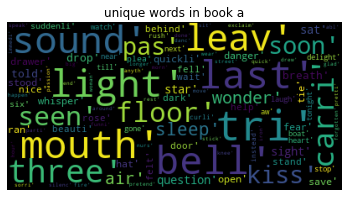

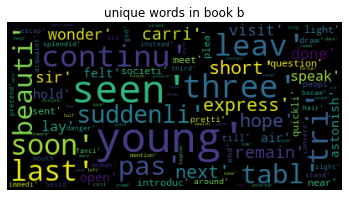

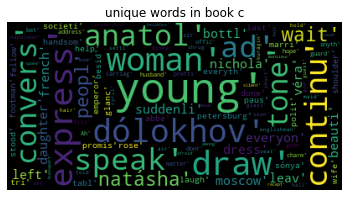

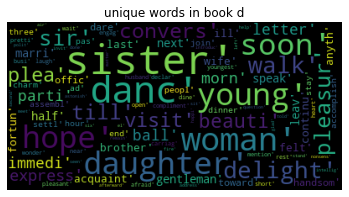

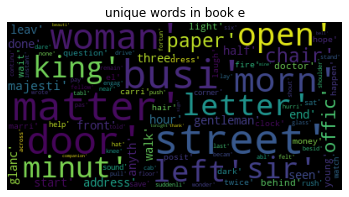

In [175]:
draw_wordcloud(0, a_dict, temp, 'unique words in book a')
draw_wordcloud(1, a_dict, temp, 'unique words in book b')
draw_wordcloud(2, a_dict, temp, 'unique words in book c')
draw_wordcloud(3, a_dict, temp, 'unique words in book d')
draw_wordcloud(4, a_dict, temp, 'unique words in book e')